# All-pole model prior $p(x,y)$

**Note:** The AP model should be considered *a special case* of the PZ model where the amplitudes $c$ are chosen in a very special way, and a rescaling parameter $g$ is introduced. In the PZ model the rescaling parameter is directly implicit in the complex amplitudes $c$.

## Model

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p, g_0) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

Now each coefficient is not a free parameter, but immediately determined by the poles $p$ and the *gain* parameter $g_0$. They are determined by the special case that the numerator of the PZ degenerates to zero-th order polynomial in $x$. In other words, the transfer function can be written:

$$ \tilde{h}(x; p, g_0) \propto {1 \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

This still needs rescaling: the units don't make sense (it must have units of time -- **we use msec in our code**), and we know that the energy $\mathcal{E}(p, g_0) = \int h(t; p, g_0)^2 dt$ must be O(1) msec.

The normal procedure is to normalize using the pole product $N_p = \prod_{k=1}^K |p_k|^2$ such that the gain $|\tilde{h}(0; p, g_0)| = 1$ at DC, see e.g. Fulop 2011. But note that this is dimensionally inconsistent (it is unitless while it should have units of time (inverse Hz)), and does not constrain $\mathcal{E}(p, g_0)$ in the way we want (in fact it will be too large). So, taking these hints seriously, we introduce the "extra" gain parameter $g_0$ such that the transfer function satisfies $\tilde{h}(0; p, g_0) = g_0$ (that's why we call it the gain). The full expression is therefore:

$$ \tilde{h}(x; p, g_0) = {g_0 N_p \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

From this it follows immediately the expression for the $c_k$ coefficients using partial fraction expansions. Here we use the "excluded pole product"

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p, g_0) = {g_0 N_p  \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

Note that this is indeed dimensionless, as it should be.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-12-13 14:30:34.703183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


## The prior for $g_0$: $p(g_0|p,E)$

We want to constrain $g_0$ such that the energy if the impulse response $\mathcal{E}(p, g) = \int h(t; p, g)^2 dt$ is equal to $E$ = O(1) msec.

We can reuse the analytic expression for $\mathcal{E}$ from the PZ model, since the AP model is just a special case of the PZ model:

$$ \mathcal{E}(p, g) = \sum_{ij=1}^{2K} g_i \alpha_i S_{ij} := E$$

Since $g_i \propto g_0$, this is quadratic in $g_0$. In other words, define $S(p)$ as

$$ \mathcal{E}(p, g_0) \equiv g_0^2 S(p)$$

where $S(p)$ only depends on the poles $p$ and has units [frequency]. Now the ME problem to be solved is trivial:

*Find $p(g_0|p,E)$ s.t. $$<\mathcal{E}> = \int dg_0\ \mathcal{E} p(g_0|p,E) = \int dg_0\ [g_0^2 S(p)] p(g_0|p,E) := E$$*

The solution is

$$ p(g_0|p,E) = N(0, \sigma_g^2)$$

where $\sigma_g^2 = E/S(p)$ which has units of [time/frequency] = [time²].

Note that the ME formalism does not imply that $h > 0$; $h \in \mathbb{R}$. So next to fixing the proper scale, and fixing the units, we also have gained an overall freedom in the polarity of the phase response by introducing $g_0$.

(And indeed, contrary to ME, we also tried a prior on $g_0^2 > 0$ which is $Exp(S_p/E)$, but it is actually less good as judged by $\log Z$ and the information $H$).

Just like the PZ case, we simply fix $E = 1\ msec$ and get good results. The convolution with samples generated from our source DGF prior are indeed O(1) in peak amplitude.

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]66.3s, 1.1min   : Loading get_vtrformants_training_data...
[Memory]67.0s, 1.1min   : Loading run_nested...
[Memory]69.8s, 1.2min   : Loading run_nested...


energy [msec] = (0.2580797997917516, 0.2580798034511303)


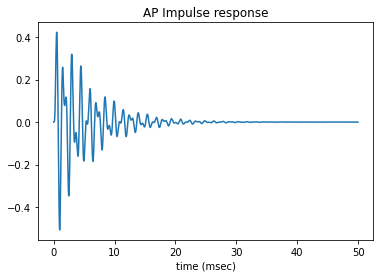

In [3]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

vtfilter = allpole.AllPoleFilter(K)
w = vtfilter.randw()

h = vtfilter.impulse_response(t, x, y, w)
plot(t, h)
title("AP Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, vtfilter.impulse_response_energy(x, y, w)))

In [4]:
vtfilter.pole_coefficients(x, y, w)

array([-0.00138317-0.18126063j,  0.0019702 +0.12079832j,
       -0.00058703-0.00770868j])

Test if the expected values $<\mathcal{E}>$ is close to its prescribed value $E = 1\ msec$. There is a larger spread compared to PZ model, and much more mass on small values of $g$. They both look like Gamma distributions.

(0.9979421693292885, 1.4116761612906836)

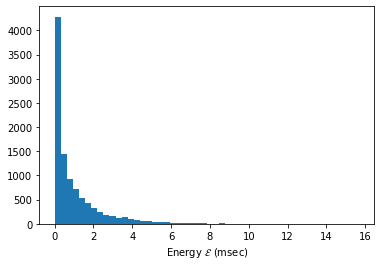

In [5]:
energies = []
for _ in range(10000):
    w = vtfilter.randw()
    energies += [vtfilter.impulse_response_energy(x, y, w)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies), std(energies) # msec

## The AP power spectrum

We compared with Scipy and it is the same.

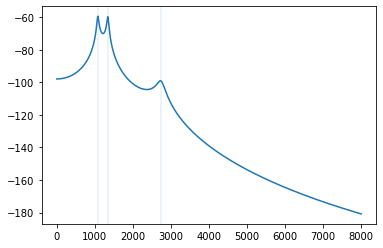

In [6]:
K = 3
vtfilter = allpole.AllPoleFilter(K)
x, y = samplexy()
w = vtfilter.randw()

f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = vtfilter.transfer_function_power_dB(f, x, y, w)
plot(f, power, label="our implementation")
for xi in x: axvline(xi, alpha=.1)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $g=(a,b)$ take on specific values. The spectral tilt is then much lower than the usual -6 dB/oct (for large $x$).

But does the $p_{PZ}(g|p,E)$ prior place any mass at that specific point?  **Yes!** -- this is totally by virtue of the $g$ parameter, because it scales the $(a, b)$ amplitudes back "into reach" of the typical set of $p_{PZ}(g|p,E)$ -- we give an example below for $K=3$. The AP point is in the "interior" of $K=3$. But also **No!** because for larger dimensions the mass associated with the neighbourhood of a points shrinks very fast (roughly 5 ban per pole, see below with KL divergence).

array([ 3.62532748e-02, -9.71580023e-02,  6.36039420e-02, -4.01118207e-03,
        2.28511683e-03, -1.16373820e-03,  4.00261033e-04, -2.10329954e-04,
        5.93539646e-07,  6.43844206e-08, -4.97803502e-02,  5.78122949e-02,
       -5.83255983e-02,  4.37842904e-02, -2.47727192e-03,  9.81286412e-04,
       -1.01169454e-03,  1.20665359e-04,  7.76011453e-07,  1.18773630e-07])

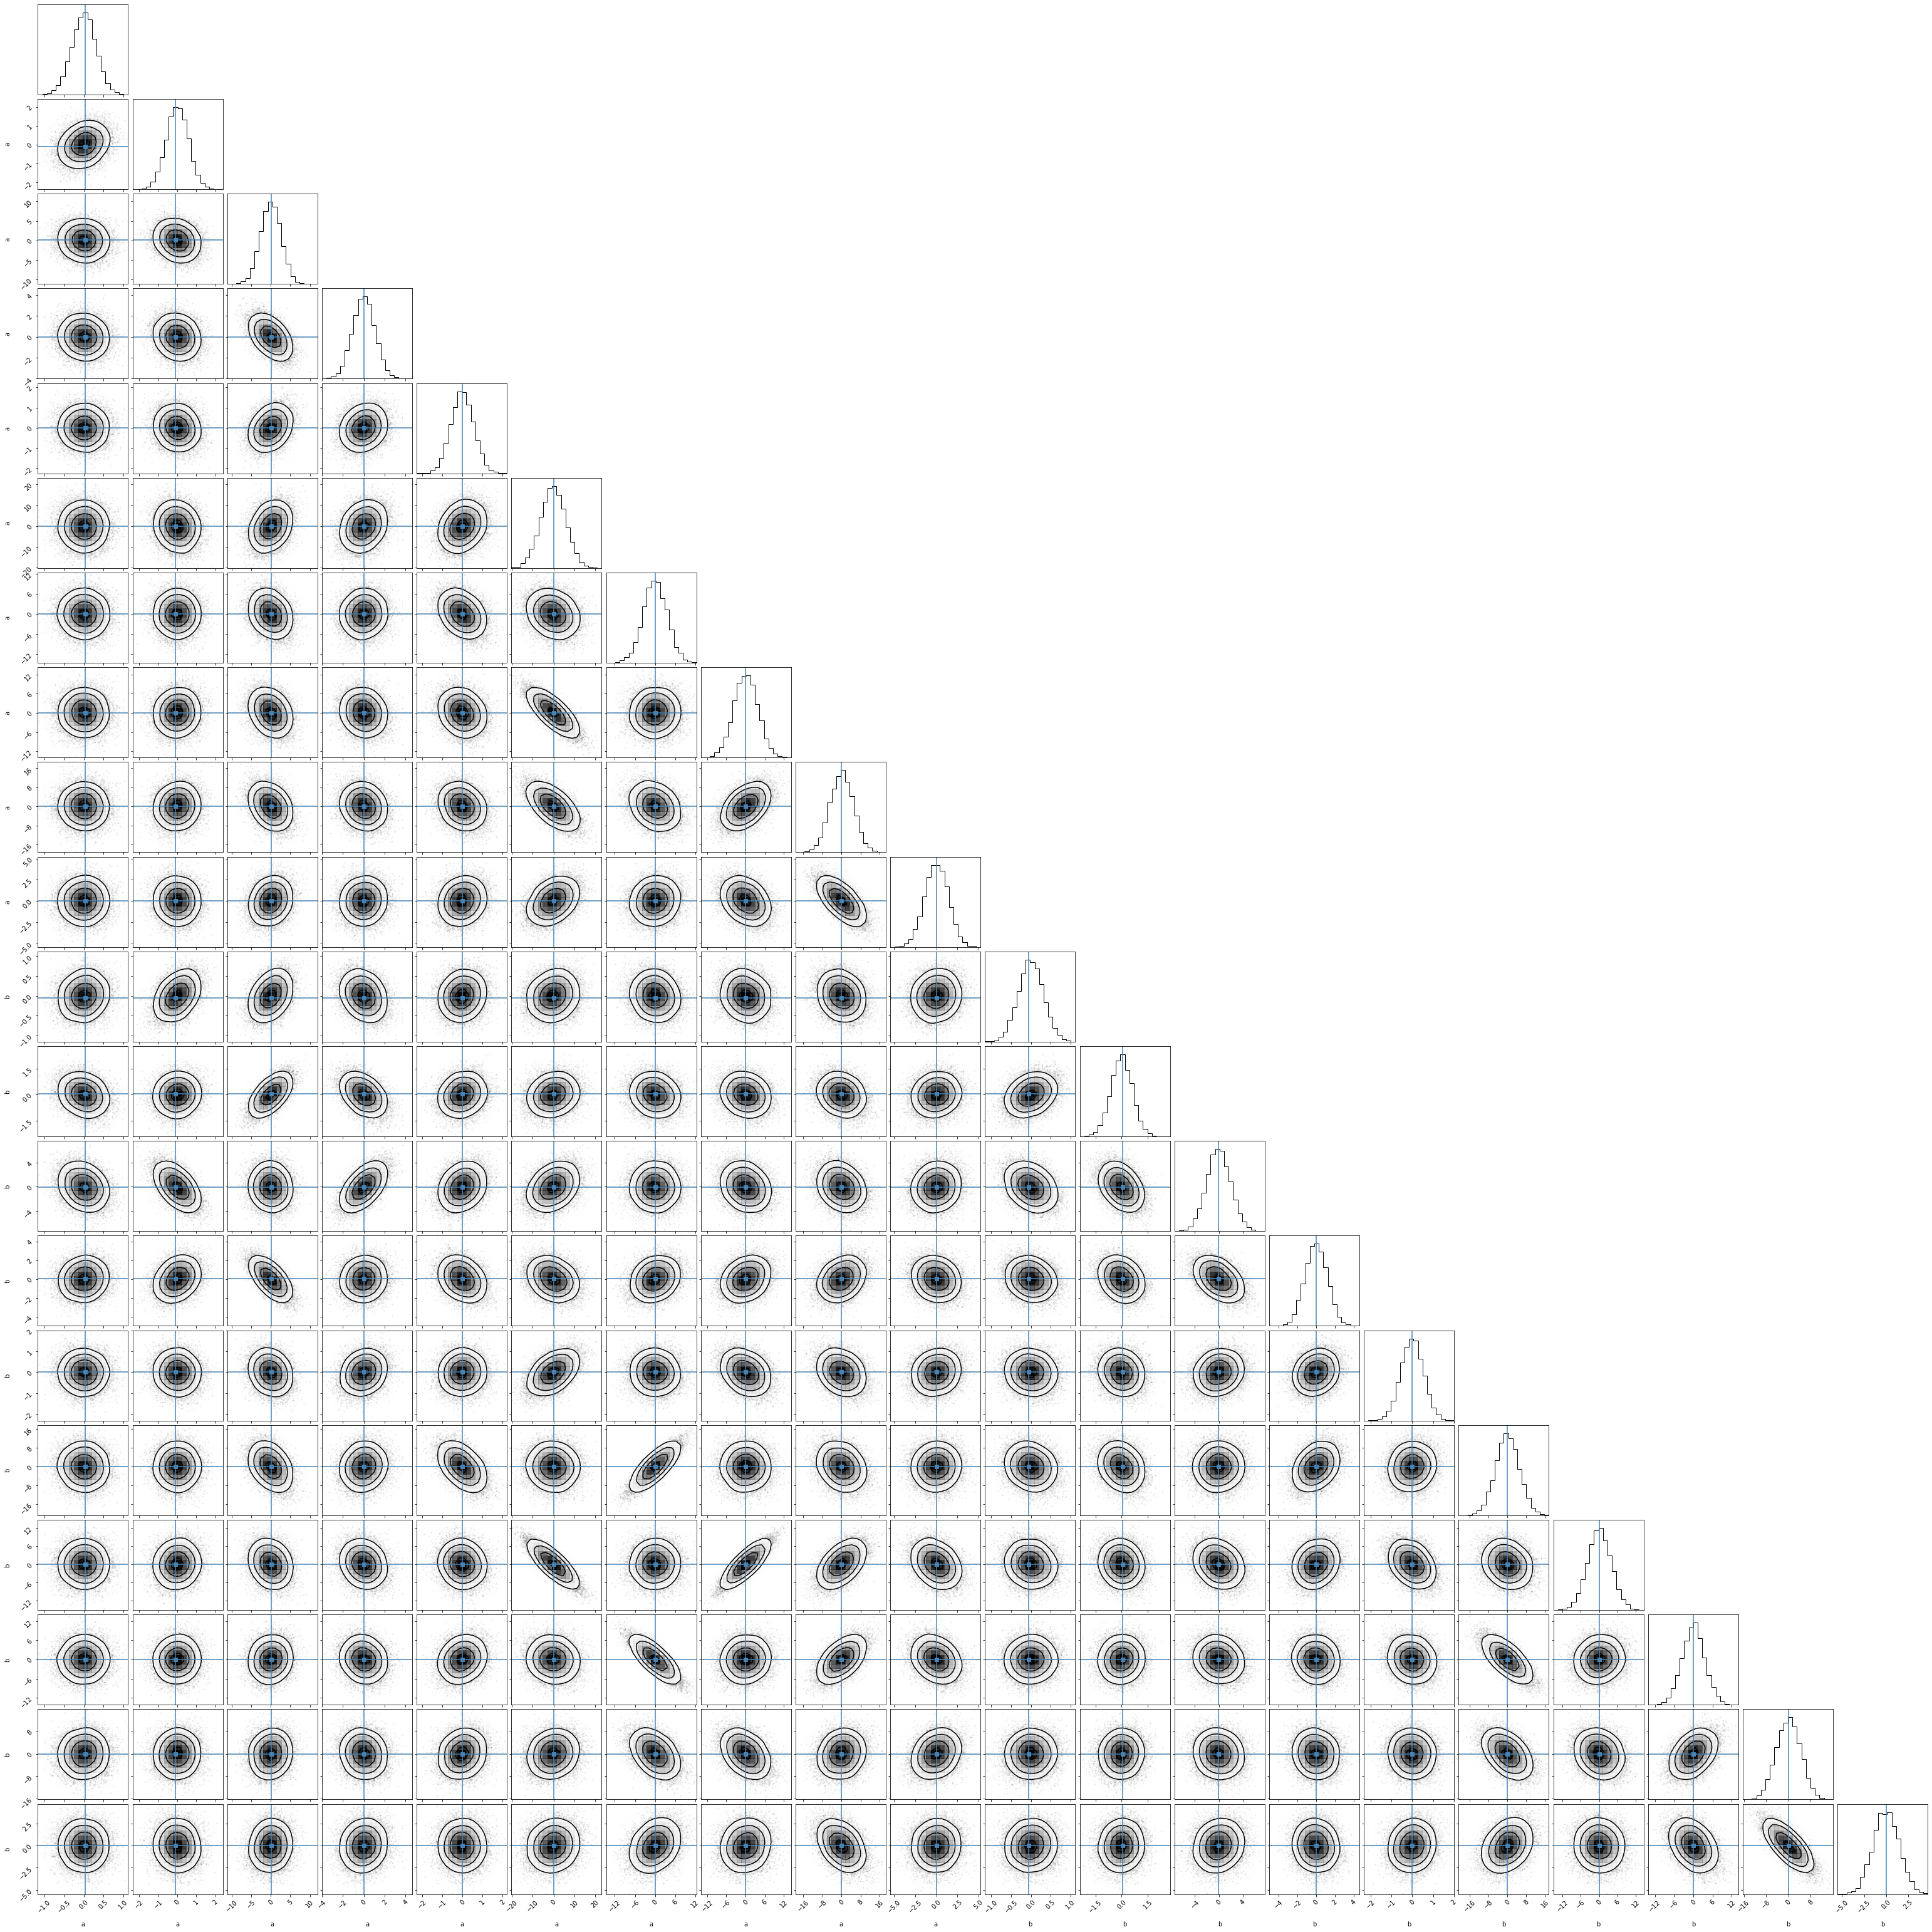

In [65]:
# Visualize the "AP" point of the PZ amplitudes given the poles
import corner
import itertools

K = 10
AP = allpole.AllPoleFilter(K)
PZ = polezero.PoleZeroFilter(K)

#x, y = samplexy(K)

xy = array([ 490.29675448,  747.13851807,  992.12581175, 1212.64983478,
             1900.8981002 , 2435.86240837, 2664.34130096, 2919.7015796 ,
             3738.16277931, 4148.62340632,   90.08928798,  162.43904763,
              515.3223018 ,  278.50813328,  188.90042454,  790.29833368,
              430.06162739,  545.05186843, 1484.89789949,  565.87403819])
x, y = np.split(xy, 2)

g_AP_sample = PZ.complex_to_real_amplitudes(
    AP.pole_coefficients(x, y, AP.randw())
)
g_PZ_samples = PZ.complex_to_real_amplitudes(
    PZ.pole_coefficients(x, y, PZ.randws(10000).T)
).T

corner.corner(
    g_PZ_samples,
    #range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = g_AP_sample
);

g_AP_sample

### Using the information $H$ to quantify the use of the $g$ parameter

Yet another way of looking at this is quantifying how much the constraint $g = (a, b) \rightarrow g{AP} = (a_{AP}, b_{AP})$ is worth in terms of information. This can be done by simply calculating the standard KL divergence between the 2 multivariate Gaussians:

$$ D_{KL}(\delta(g - g_{AP})|N(g|0, \Sigma)) = \infty $$

Here $\Sigma = {E \over 2K} S(p)^{-1}$ (see polezero.ipynb).

So in practice we relax the problem (like we did in calculating the density $p(u)$) where we add a "tolerance" for the amplitudes, which determines our precision -- how close should an $g \sim N(0, \Sigma)$ be to $g_{AP}$ to be reckoned "close"?

Since we are directly in the amplitude domain, it is reasonable to take the noise floor power $\delta_n^2$ as the tolerance (in fact, the square root of it). So we relax the following way

$$ \delta(g - g_{AP}) \rightarrow N(g|g_{AP}, \delta_n^2 I_{2K}) $$

This yields an analytical formula for $D_{KL}(N_{AP}|N_{PZ})$.

The resulting distribution of $D_KL$'s for $x,y \sim p(F,B)$ and $g \sim p(g|p,E)$ are heavy-tailed, so we plot medians and IQRs for them. In general we see that
- The KL divergences in bans are perhaps a bit larger than hoped (given $\delta_n^2 = -60\ dB$, and since they grow linearly as $K$, finding the AP model in the PZ parameter space becomes rapidly impossible (at least at the given tolerance).
- The *difference* in KL divergence between an AP model *with* $g \sim p(g|p,E)$ and an AP model *without* $g$ (i.e. $g := 1$) are **independent** of $\delta^2_n$ and are enormous. So here is yet another reason why $g$ is extremely important.

Tolerance (amplitude): 0.001


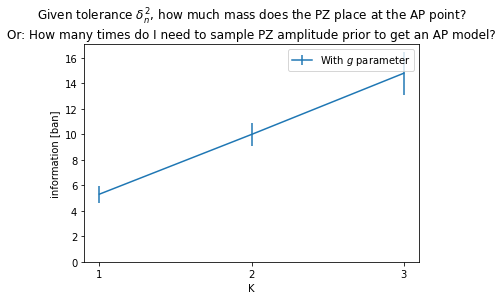

KL increases per dimension of $K$ as 4.737651297793402 ban/dimension


In [74]:
#%%time
# Very slow
from lib import util
import scipy

def kldiv(AP, PZ, x, y, w, delta2, E_msec = 1.):
    E = len(x)
    E = E_msec/1000.
    S = PZ.overlap_matrix(x, y)
    precision_matrix = (2*K)/E*S
    
    c = AP.pole_coefficients(x, y, w)
    ab_AP = PZ.complex_to_real_amplitudes(c)
    
    # Using an analytic formula, but this is just KL(MVN0, MVN1)
    KL_nats = 0.5*(\
        2*K/E*delta2*np.trace(S) +\
        2*K/E*ab_AP.T @ S @ ab_AP +\
        (-2*K) +\
        2*K*np.log(E/(2*K)) - np.linalg.slogdet(S)[1] - 2*K*np.log(delta2)
    )
    
    return util.nats_to_ban(KL_nats) # ban

nsamp = 200
Ks = (1, 2, 3)
delta2 = constants.NOISE_FLOOR_POWER
print("Tolerance (amplitude):", sqrt(delta2))

KLs = np.zeros((nsamp, len(Ks)))
    
for j, K in enumerate(Ks):
    AP = allpole.AllPoleFilter(K)
    PZ = polezero.PoleZeroFilter(K)
    for i in range(nsamp):
        x, y = samplexy(K)
        w = AP.randw()
        KLs[i, j] = kldiv(AP, PZ, x, y, w, delta2)
    
# Plot the bans for AP with g
errorbar(Ks, np.median(KLs, axis=0), scipy.stats.iqr(KLs, axis=0), label="With $g$ parameter")
legend()
xlabel("K")
xticks(Ks)
ylabel("information [ban]")
ylim(0, None)
title("Given tolerance $\delta_n^2$, how much mass does the PZ place at the AP point?\nOr: How many times do I need to sample PZ amplitude prior to get an AP model?");
show()

rico = np.polyfit(Ks, np.median(KLs, axis=0), 1)[0]
print(f"KL increases per dimension of $K$ as {rico} ban/dimension")

## Fitting the TFB samples

In [15]:
%%time
samples = bandwidth.get_TFB_samples()

[Memory]1589.2s, 26.5min: Loading get_TFB_samples...
CPU times: user 14 ms, sys: 3.9 ms, total: 17.9 ms
Wall time: 17.5 ms


In [18]:
fitted = allpole.get_fitted_TFB_samples(return_full=True)

[Memory]1707.2s, 28.5min: Loading get_TFB_samples...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading run_nested...
[Memory]1707.2s, 28.5min: Loading r

In [33]:
K = 10
sample_index = 101

def getfit(K, sample_index):
    return fitted[(K-3)*200+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results, context = fit['results']

Summary
nlive: 60
niter: 1449
ncall: 180222
eff(%):  0.837
logz: -20.164 +/-  0.590


None

'Information (bans)'

7.626573565087624

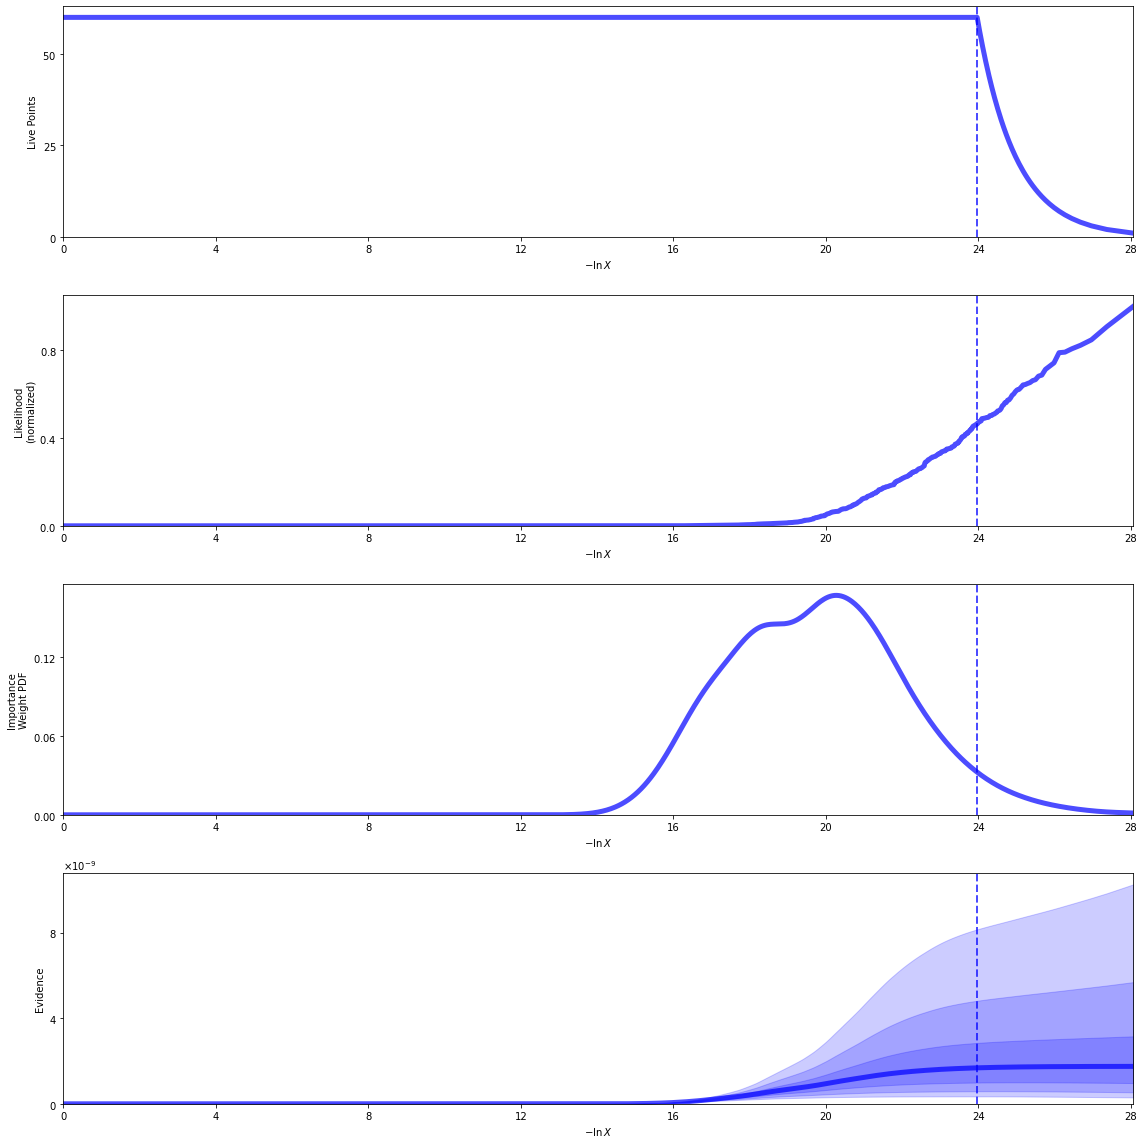

Quantiles:
$x_{1}$ [(0.025, 104.48731896053268), (0.5, 156.60539002692053), (0.975, 446.2951050482437)]
Quantiles:
$x_{2}$ [(0.025, 432.13295890978446), (0.5, 444.66062530477063), (0.975, 584.2436908098894)]
Quantiles:
$x_{3}$ [(0.025, 535.4501917871147), (0.5, 582.4922868941746), (0.975, 874.6690726908953)]
Quantiles:
$x_{4}$ [(0.025, 649.2726514424883), (0.5, 715.7757630361114), (0.975, 1188.2243521692449)]
Quantiles:
$x_{5}$ [(0.025, 1090.709138589371), (0.5, 1126.687719512218), (0.975, 1627.7817059110735)]
Quantiles:
$x_{6}$ [(0.025, 1164.399112039235), (0.5, 1185.694061790487), (0.975, 1720.7046574575593)]
Quantiles:
$x_{7}$ [(0.025, 1382.279878255104), (0.5, 1645.3151498545762), (0.975, 2285.8399589532796)]
Quantiles:
$x_{8}$ [(0.025, 2104.732425785964), (0.5, 2283.523334377251), (0.975, 2339.326618897829)]
Quantiles:
$x_{9}$ [(0.025, 2228.074027867748), (0.5, 2315.5949608697115), (0.975, 2375.3055529644444)]
Quantiles:
$x_{10}$ [(0.025, 2298.5565530749923), (0.5, 2363.8012815676

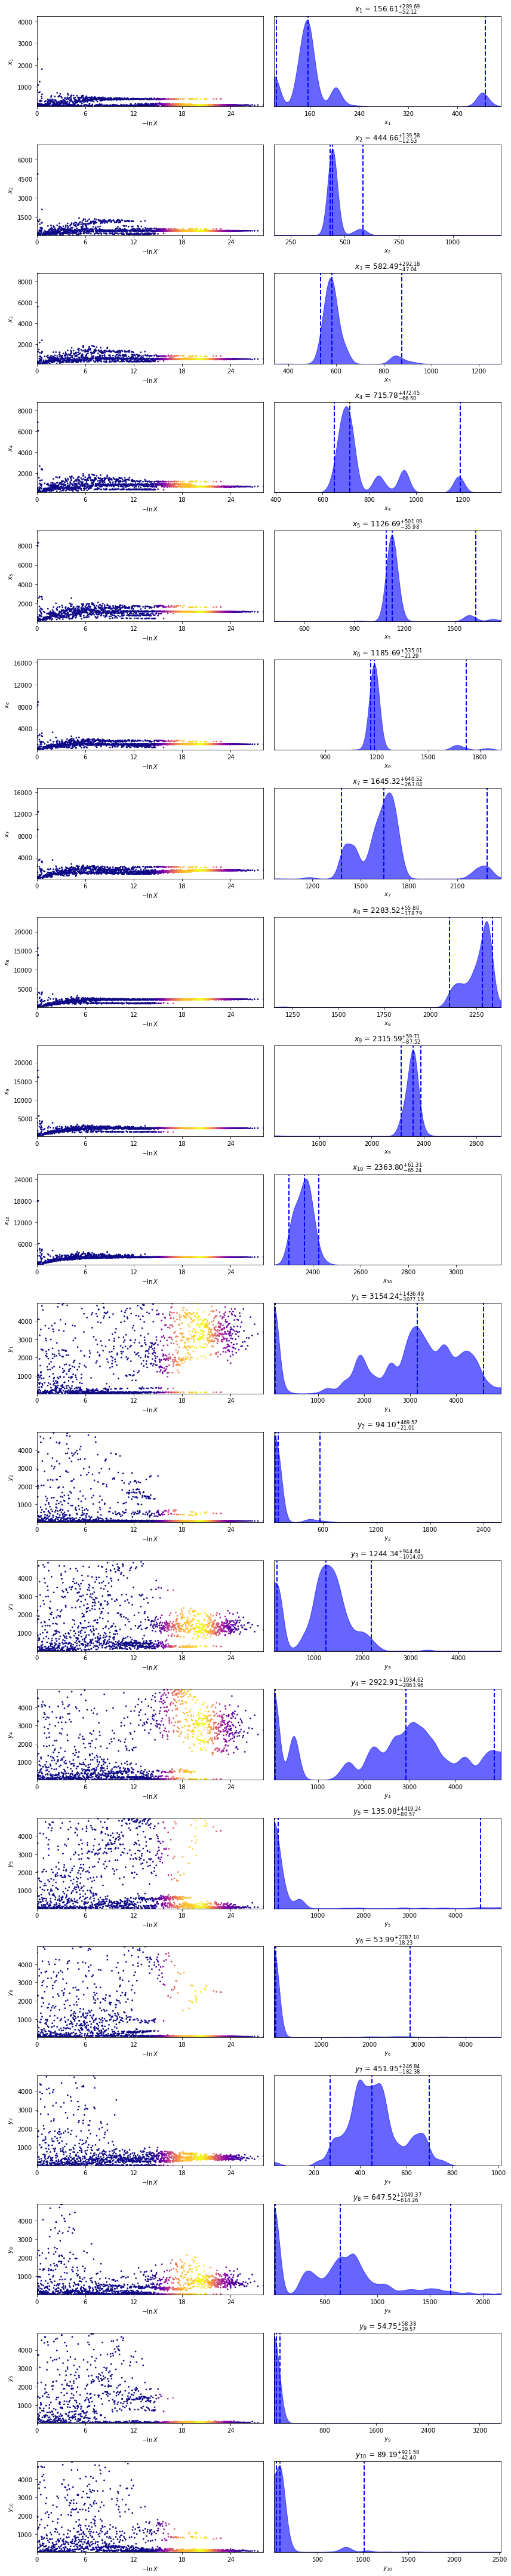

In [34]:
from lib import util

util.dyplot(results, context['dimlabels'], cornerplot=False)

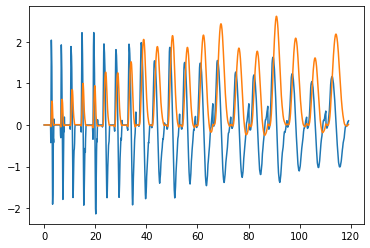

In [35]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

Num formants: 3
F vs F_true: [ 450. 1160. 2316.] [ 438.57 1185.84 2320.92]
B vs B_true: [42.28 42.84 33.85] [48.47 33.65 56.73]
Errors: 12.008831612016605 4.703797574973222 312.64709070683557
mu2(analytical) [msec] = 3.939210715712008


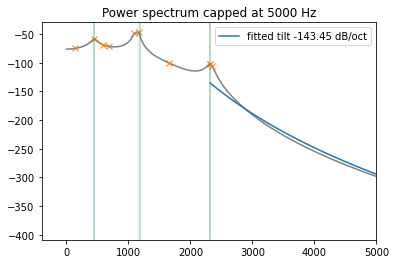

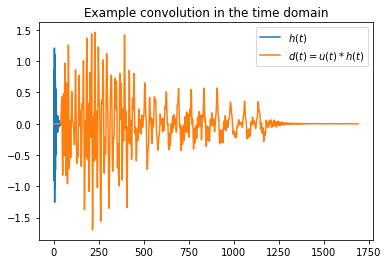

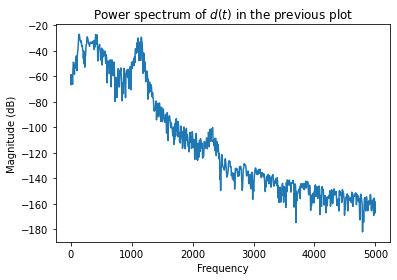

In [41]:
from IPython.display import Audio

def sample_posterior(results):
    return util.resample_equal(results, 1).squeeze()

def analyze(sample, context, w=None):
    x, y = context['unpack'](sample)
    
    vtfilter = context['vtfilter']
    if w is None:
        w = vtfilter.randw()

    f = context['f']
    power = vtfilter.transfer_function_power_dB(
        f, x, y, w
    )

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = context['F_true'][-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = vtfilter.impulse_response_energy(x, y, w)
    
    print("Num formants:", len(F))
    if len(F) == 3:
        F_err = np.sum(((F - context['F_true'])/context['sigma_F'])**2)
        B_err = np.sum(((B - context['B_true'])/context['sigma_B'])**2)
        print("F vs F_true:", np.round(F, 2), np.round(context['F_true'], 2))
        print("B vs B_true:", np.round(B, 2), np.round(context['B_true'], 2))
    else:
        F_err = inf
        B_err = inf
    
    tilt_err = ((tilt - context['tilt_target'])/context['sigma_tilt'])**2
    print("Errors:", F_err, B_err, tilt_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = vtfilter.transfer_function_power_dB(f, x, y, w)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    for Fi in context['F_true']: axvline(Fi, alpha=.3, color="green")
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = vtfilter.impulse_response(t, x, y, w)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))
    
    return x, y

x, y = analyze(sample_posterior(results), context)